# Key Times/Frames Table Generation

## Load Packages and Classes

In [2]:
import sys
sys.path.append('/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/')

from scripts.data_processing.RADARDataCapture import FMCWRADARDataCapture
from scripts.data_processing.MOCAPDataCapture import MOCAPDataCapture
from scripts.data_processing.FPDataCapture import FPDataCapture
from scripts.data_processing.tsv_processor_knee_angles import TSVProcessorKnee
import h5py
import os
import numpy as np
import pandas as pd
import imageio
import matplotlib.pyplot as plt
from datetime import datetime
import statistics
from matplotlib import animation

## Seconds Per Frame, Start Time/Frame, End Time/Frame

### Load and Preprocess Actuator Vel Data, THEN Find Actuator Start and End Times....Load and Preprocess Radar Data into RDMs (4,1000,256,128), THEN Find Actuator Start and End Frames
### Calcuate Seconds Per Frame
### Save Key Times/Frames CSV with header: RADAR_capture,MOCAP_Start_Time,MOCAP_End_Time,RADAR_Start_Frame,RADAR_End_Frame,Seconds_per_Frame

In [2]:
ACTUATOR_BUFFER_TIME_END = 2.75
ACTUATOR_BUFFER_TIME_START = 5.7

# # Define the lists of parameters
participants = ['01', '02', '03', '04', '05', '08', '10', '12', '13', '14', '15', '16', '18', '22', '24']
# participants = ['04', '05']
movements = ["MNTRL", "MNTRR"]
# movements = ["MNTRR"]
versions = ["V1", "V2", "V3"]
# versions = ["V1"]

# Initialize a list to store seconds per frame for each valid combination
seconds_per_frame_list = []
problem_list = []
RADAR_seconds_per_frame_list = []

# Loop over each combination of participant, movement, and version
for participant in participants:
    for movement in movements:
        for version in versions:
            # Construct file paths
            MOCAP_capture = f"{participant}_{movement}_MC_{version}"
            RADAR_capture = f"{participant}_{movement}_RR_{version}"
            
            MOCAP_spot_check_path = f"/Volumes/FourTBLaCie/Yoga_Study_MOCAP_Data/{participant}/tsv/{MOCAP_capture}.tsv"

            RADAR_h5_path = f"/Volumes/FourTBLaCie/Yoga_Study_RADAR_Data_Renamed/{participant}/{RADAR_capture}.h5"

            # Check if RADAR file exists
            if os.path.isfile(RADAR_h5_path):
                try:
                    mocap = MOCAPDataCapture(MOCAP_spot_check_path)
                    mocap.find_actuator_start_end_direction_changes()
                    print(mocap.start_actuator_time, mocap.end_actuator_time)
                except Exception as e:
                    print(f"An error occurred: {e}")
                    print("Actuator Vel Not Found")
                    problem_list.append((participant,movement,version))
                    continue

                # Process RADAR data
                radar = FMCWRADARDataCapture(file_path=RADAR_h5_path)
                dataCubes = radar.load_and_save()
                processed_data = radar.range_doppler_processing(dataCubes)
                peaks, match_scores_summed = radar.slide_normalized_actuator_pattern_over_data(processed_data)
                
                print(peaks)

                # Ensure valid peaks for calculation
                if len(peaks) > 1:
                    seconds_per_frame = (mocap.end_actuator_time - mocap.start_actuator_time) / (peaks[1] - peaks[0])
                    df_key_capture_times_frames = RADAR_seconds_per_frame_list.append({'RADAR_capture': RADAR_capture, 'Seconds_per_Frame': seconds_per_frame, 'MOCAP_Start_Time': mocap.start_actuator_time, 'MOCAP_End_Time': mocap.end_actuator_time, 'RADAR_Start_Frame': peaks[0], 'RADAR_End_Frame': peaks[1]})
                    print(f"{RADAR_capture} seconds per frame: {seconds_per_frame}")
                    if seconds_per_frame > 0.039 or seconds_per_frame < 0.036:
                        problem_list.append((participant,movement,version))
                        print(f"PROBLEM with timing of {(participant,movement,version)}")
                    seconds_per_frame_list.append(seconds_per_frame)
                else:
                    print(f"Error: Invalid peaks for {MOCAP_capture} and {RADAR_capture}")
            else:
                print(f"RADAR file not found for {RADAR_capture}")
            

# Calculate and print the average seconds per frame after all iterations
if seconds_per_frame_list:
    average_seconds_per_frame = sum(seconds_per_frame_list) / len(seconds_per_frame_list)
    print(f"Average seconds per frame: {average_seconds_per_frame}")
    # print(f"The standard deviation of the set is {statistics.stdev(seconds_per_frame_list)}")
else:
    print("No valid data found to calculate average seconds per frame.")

# Once the loop is done, create the DataFrame
df_key_capture_times_frames = pd.DataFrame(RADAR_seconds_per_frame_list)


# TODO Create a trim function that removes ACTUATOR_BUFFER_TIME from the end time, and ACTUATOR_BUFFER_TIME * frames_per_second from the end frame...Also Trims start time by 
print(df_key_capture_times_frames.head())

# Round Seconds_per_Frame to the nearest 10,000th
df_key_capture_times_frames['Seconds_per_Frame'] = df_key_capture_times_frames['Seconds_per_Frame'].clip(lower=0.036, upper=0.039)
df_key_capture_times_frames['Seconds_per_Frame'] = df_key_capture_times_frames['Seconds_per_Frame'].round(5)

df_key_capture_times_frames.MOCAP_Start_Time = (df_key_capture_times_frames.MOCAP_Start_Time + ACTUATOR_BUFFER_TIME_START).round(2)
df_key_capture_times_frames.MOCAP_End_Time = (df_key_capture_times_frames.MOCAP_End_Time - ACTUATOR_BUFFER_TIME_END).round(2)

df_key_capture_times_frames['RADAR_Start_Frame'] = df_key_capture_times_frames['RADAR_Start_Frame'] + (ACTUATOR_BUFFER_TIME_START / df_key_capture_times_frames['Seconds_per_Frame']).astype(int)
df_key_capture_times_frames['RADAR_End_Frame'] = df_key_capture_times_frames['RADAR_End_Frame'] - (ACTUATOR_BUFFER_TIME_END / df_key_capture_times_frames['Seconds_per_Frame']).astype(int)
print(df_key_capture_times_frames.head())

# Save the DataFrame to a CSV file
csv_file_path = '/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/metadata/key_capture_times_frames_v1.csv'  # Adjust the path as needed
df_key_capture_times_frames.to_csv(csv_file_path, index=False)

print(f'DataFrame saved to {csv_file_path}')


Processing File: 01_MNTRL_MC_V1.tsv
/Volumes/FourTBLaCie/Yoga_Study_MOCAP_Data/01/tsv/01_MNTRL_MC_V1_pos.tsv
/Volumes/FourTBLaCie/Yoga_Study_MOCAP_Data/01/tsv/01_MNTRL_MC_V1_vel.tsv
Start actuator time: 1.86, End actuator time: 33.32
1.86 33.32
[44, 907]
01_MNTRL_RR_V1 seconds per frame: 0.03645422943221321
Processing File: 01_MNTRL_MC_V2.tsv
/Volumes/FourTBLaCie/Yoga_Study_MOCAP_Data/01/tsv/01_MNTRL_MC_V2_pos.tsv
/Volumes/FourTBLaCie/Yoga_Study_MOCAP_Data/01/tsv/01_MNTRL_MC_V2_vel.tsv
Start actuator time: 1.9000000000000001, End actuator time: 33.15
1.9000000000000001 33.15
[41, 898]
01_MNTRL_RR_V2 seconds per frame: 0.03646441073512252
Processing File: 01_MNTRL_MC_V3.tsv
/Volumes/FourTBLaCie/Yoga_Study_MOCAP_Data/01/tsv/01_MNTRL_MC_V3_pos.tsv
/Volumes/FourTBLaCie/Yoga_Study_MOCAP_Data/01/tsv/01_MNTRL_MC_V3_vel.tsv
Start actuator time: 1.92, End actuator time: 34.63
1.92 34.63
[43, 938]
01_MNTRL_RR_V3 seconds per frame: 0.03654748603351955
Processing File: 01_MNTRR_MC_V1.tsv
/Volumes/

## Check to ensure they are very similar

In [3]:
import pandas as pd

# Load the CSV files
file1 = '/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/metadata/key_capture_times_frames_v1.csv'
file2 = '/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/metadata/MOCAP_FP_RADAR_FU_Stable_Break_FD_TIME_FRAMES_v3.csv'

df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# Select only the relevant columns from each file for comparison
df1_subset = df1[['RADAR_capture', 'Seconds_per_Frame', 'MOCAP_Start_Time', 'MOCAP_End_Time', 'RADAR_Start_Frame', 'RADAR_End_Frame']]
df2_subset = df2[['RADAR_capture', 'Seconds_per_Frame', 'MOCAP_Start_Time', 'MOCAP_End_Time', 'RADAR_Start_Frame', 'RADAR_End_Frame']]

# Merge the two DataFrames on 'RADAR_capture'
merged_df = df1_subset.merge(df2_subset, on='RADAR_capture', suffixes=('_file_New', '_file_OG'))

# Consolidate discrepancies for each 'RADAR_capture'
discrepancies = []

for index, row in merged_df.iterrows():
    diff_dict = {"RADAR_capture": row['RADAR_capture']}
    for column in ['Seconds_per_Frame', 'MOCAP_Start_Time', 'MOCAP_End_Time', 'RADAR_Start_Frame', 'RADAR_End_Frame']:
        if row[f"{column}_file_New"] != row[f"{column}_file_OG"]:
            diff_dict[column] = {
                "file_New": row[f"{column}_file_New"],
                "file_OG": row[f"{column}_file_OG"]
            }
    if len(diff_dict) > 1:  # Only add rows with discrepancies
        discrepancies.append(diff_dict)

# Convert to DataFrame for easy viewing
discrepancies_df = pd.DataFrame(discrepancies)

# Display the discrepancies
print(discrepancies_df)


      RADAR_capture                     MOCAP_Start_Time  \
0    01_MNTRL_RR_V1  {'file_New': 7.56, 'file_OG': 7.33}   
1    01_MNTRL_RR_V1  {'file_New': 7.56, 'file_OG': 7.33}   
2    01_MNTRL_RR_V1  {'file_New': 7.56, 'file_OG': 7.33}   
3    01_MNTRL_RR_V2   {'file_New': 7.6, 'file_OG': 7.37}   
4    01_MNTRL_RR_V2   {'file_New': 7.6, 'file_OG': 7.37}   
..              ...                                  ...   
266  24_MNTRR_RR_V2  {'file_New': 7.61, 'file_OG': 7.59}   
267  24_MNTRR_RR_V2  {'file_New': 7.61, 'file_OG': 7.59}   
268  24_MNTRR_RR_V3                                  NaN   
269  24_MNTRR_RR_V3                                  NaN   
270  24_MNTRR_RR_V3                                  NaN   

                     RADAR_Start_Frame                    RADAR_End_Frame  \
0    {'file_New': 200, 'file_OG': 194}  {'file_New': 832, 'file_OG': 831}   
1    {'file_New': 200, 'file_OG': 194}  {'file_New': 832, 'file_OG': 831}   
2    {'file_New': 200, 'file_OG': 194}  {'file_N

In [4]:
print(discrepancies_df)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(discrepancies_df)

      RADAR_capture                     MOCAP_Start_Time  \
0    01_MNTRL_RR_V1  {'file_New': 7.56, 'file_OG': 7.33}   
1    01_MNTRL_RR_V1  {'file_New': 7.56, 'file_OG': 7.33}   
2    01_MNTRL_RR_V1  {'file_New': 7.56, 'file_OG': 7.33}   
3    01_MNTRL_RR_V2   {'file_New': 7.6, 'file_OG': 7.37}   
4    01_MNTRL_RR_V2   {'file_New': 7.6, 'file_OG': 7.37}   
..              ...                                  ...   
266  24_MNTRR_RR_V2  {'file_New': 7.61, 'file_OG': 7.59}   
267  24_MNTRR_RR_V2  {'file_New': 7.61, 'file_OG': 7.59}   
268  24_MNTRR_RR_V3                                  NaN   
269  24_MNTRR_RR_V3                                  NaN   
270  24_MNTRR_RR_V3                                  NaN   

                     RADAR_Start_Frame                    RADAR_End_Frame  \
0    {'file_New': 200, 'file_OG': 194}  {'file_New': 832, 'file_OG': 831}   
1    {'file_New': 200, 'file_OG': 194}  {'file_New': 832, 'file_OG': 831}   
2    {'file_New': 200, 'file_OG': 194}  {'file_N

## Force Plate Data

### Foot Lift/ Lower Pairs

In [5]:
import os
import pandas as pd

# Define the lists of parameters
participants = ['01', '02', '03', '04', '05', '08', '10', '12',
                '13', '14', '15', '16', '18', '22', '24']
movements = ["MNTRL", "MNTRR"]
versions = ["V1", "V2", "V3"]

# Initialize a list to store the results
results_list = []

# Loop over each combination of participant, movement, and version
for participant in participants:
    for movement in movements:
        for version in versions:
            # Construct base file name and paths
            base_file_name = f"{participant}_{movement}_MC_{version}"
            base_file_path = f"/Volumes/FourTBLaCie/Yoga_Study_FP_1and2_MNTR/{participant}/{base_file_name}.tsv"

            # Paths for _f_1.tsv and _f_2.tsv
            file_path_f_1 = base_file_path.replace(".tsv", "_f_1.tsv")
            file_path_f_2 = base_file_path.replace(".tsv", "_f_2.tsv")

            if os.path.exists(file_path_f_1) and os.path.exists(file_path_f_2):
                try:
                    # Create FPDataCapture object
                    fp_data_capture = FPDataCapture(base_file_path)

                    # Call identify_foot_lift()
                    foot_lift_times, foot_down_times = fp_data_capture.identify_foot_lift()

                    # Get RADAR_Capture from the object
                    RADAR_capture = fp_data_capture.RADAR_Capture

                    # For each foot up time, collect the data
                    for i in range(len(foot_lift_times)):
                        t_foot_up = foot_lift_times[i]
                        t_foot_down = foot_down_times[i] if i < len(foot_down_times) else ''

                        result = {
                            'RADAR_capture': RADAR_capture,
                            't_foot_up': t_foot_up,
                            't_foot_down': t_foot_down
                        }

                        results_list.append(result)

                except Exception as e:
                    print(f"Error processing {base_file_name}: {e}")

            else:
                print(f"Files for {base_file_name} not found.")

# Convert results_list to DataFrame and save to CSV
results_df = pd.DataFrame(results_list)
results_df.to_csv('/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/metadata/foot_lift_times.csv', index=False)


## GO THROUGH BY HAND AND LOOK FOR OUTLIERS, ALSO NOTE DURING CAPTURES, ANY TREE CAPTURE WHERE AN EXTRA TOUCHDOWN OCCURS!!!

### Combine foot_up/foot_down table with Start/End Frames/Times Table

In [6]:
import pandas as pd

# Paths to the CSV files
csv_path1 = '/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/metadata/foot_lift_times.csv'  # Update with your actual path
csv_path2 = '/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/metadata/key_capture_times_frames_v1.csv'  # Update with your actual path

# Load the CSVs into DataFrames
df_lift_down_times = pd.read_csv(csv_path1)
df_radar_info = pd.read_csv(csv_path2)

# Merge the DataFrames on 'RADAR_capture'
merged_df = pd.merge(df_lift_down_times, df_radar_info, on='RADAR_capture')

# Initialize the list to store the structured data
structured_data = []

# Process each row in the merged DataFrame
for index, row in merged_df.iterrows():
    # Extract foot up and foot down times
    t_foot_up = row['t_foot_up']
    t_foot_down = row['t_foot_down']
    
    # If t_foot_down is empty or NaN, use MOCAP_End_Time
    if pd.isna(t_foot_down) or t_foot_down == '':
        t_foot_down = row['MOCAP_End_Time']
        is_final_tx = True
    else:
        is_final_tx = False
    
    # Calculate frame_foot_up and frame_end for each interval
    frame_foot_up = int(((t_foot_up - row['MOCAP_Start_Time']) / row['Seconds_per_Frame']) + row['RADAR_Start_Frame'])
    frame_end = int(((t_foot_down - row['MOCAP_Start_Time']) / row['Seconds_per_Frame']) + row['RADAR_Start_Frame'])
    
    # Append the structured data
    structured_data.append({
        'RADAR_capture': row['RADAR_capture'],
        'MOCAP_Start_Time': row['MOCAP_Start_Time'],
        'MOCAP_End_Time': row['MOCAP_End_Time'],
        'RADAR_Start_Frame': row['RADAR_Start_Frame'],
        'RADAR_End_Frame': row['RADAR_End_Frame'],
        'Seconds_per_Frame': row['Seconds_per_Frame'],
        'tx': None,  # We'll assign tx numbers later
        'is_final_tx': is_final_tx,
        't_foot_up': t_foot_up,
        't_foot_down': t_foot_down,
        'frame_foot_up': frame_foot_up,
        'frame_end': frame_end
    })

# Create a new DataFrame from the structured data
new_df = pd.DataFrame(structured_data)

# Assign tx numbers per RADAR_capture
new_df['tx'] = new_df.groupby('RADAR_capture').cumcount() + 1

# Reorder columns as specified
new_df = new_df[['RADAR_capture', 'MOCAP_Start_Time', 'MOCAP_End_Time', 'RADAR_Start_Frame',
                 'RADAR_End_Frame', 'Seconds_per_Frame', 'tx', 'is_final_tx', 't_foot_up',
                 't_foot_down', 'frame_foot_up', 'frame_end']]

# Save to CSV file
output_csv_path = '/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/metadata/FP_RADAR_START_END_TIME_FRAMES.csv'  # Update with your desired path
new_df.to_csv(output_csv_path, index=False)

print(f'Data saved to {output_csv_path}')


Data saved to /Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/metadata/FP_RADAR_START_END_TIME_FRAMES.csv


## MOCAP Data

### t_stable and t_break based on Knee Angle

Process Knee Angle CSVs

In [7]:
# Update the path to your CSV file
radar_captures_csv = '/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/metadata/FP_RADAR_START_END_TIME_FRAMES.csv'
df_captures = pd.read_csv(radar_captures_csv)

# Get the list of unique RADAR captures
radar_captures = df_captures['RADAR_capture'].unique()

# Set the desired output folder for the processed CSV files
output_folder = '/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/preprocessed/latest/all_knee_angle_csvs'

# Import the TSVProcessorKnee class (ensure it's correctly defined)
# from your_module import TSVProcessorKnee

for radar_capture in radar_captures:
    # Replace 'RR' with 'MC' to get the MOCAP capture name
    mocap_capture = radar_capture.replace('_RR_', '_MC_')
    # Extract participant ID from the capture name
    participant_id = radar_capture.split('_')[0]
    # Construct the path to the MOCAP TSV file
    mocap_tsv_path = f"/Volumes/FourTBLaCie/Yoga_Study_MOCAP_Data/{participant_id}/tsv/{mocap_capture}_pos.tsv"
    
    # Check if the TSV file exists
    if os.path.exists(mocap_tsv_path):
        # Create an instance of TSVProcessorKnee
        tsv_processor = TSVProcessorKnee(
            input_folder=os.path.dirname(mocap_tsv_path),
            participant_id=participant_id,
            output_folder=output_folder  # Ensure the class uses this output_folder
        )
        # Process the TSV file to generate the CSV
        df_with_angles = tsv_processor.process_tsv(mocap_tsv_path)
        output_file_path = os.path.join(output_folder,f"{mocap_capture}_pos_angle.csv")
        df_with_angles.to_csv(output_file_path, index=False, header=True)
    else:
        print(f"File not found: {mocap_tsv_path}")


df_header
                                 Value
NO_OF_FRAMES                      4000
NO_OF_DATA_TYPES                    57
FREQUENCY                          100
TIME_STAMP        2023-04-18, 14:08:58
DATA_INCLUDED                 Position
      frame   time participant_id       pose  Actuator_pos_X  Actuator_pos_Y  \
0         0   0.00             01      Tpose     5054.442871      413.312988   
1         1   0.01             01      Tpose     5054.480957      413.308990   
2         2   0.02             01      Tpose     5054.434082      413.304993   
3         3   0.03             01      Tpose     5054.412109      413.294006   
4         4   0.04             01      Tpose     5054.437012      413.272003   
...     ...    ...            ...        ...             ...             ...   
3995   3995  39.95             01  Tree Left     5073.059082      410.134003   
3996   3996  39.96             01  Tree Left     5073.050781      410.102997   
3997   3997  39.97             01  T

KeyboardInterrupt: 

Dynamic Thresholding Hysteresis Function

In [13]:
import numpy as np

# Smoothing the signal with a simple moving average
def smooth_signal(signal, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(signal, window, 'same')


def dynamic_thresholding_with_hysteresis(signal, adjust_std, FU=700, FD=3300, window_size=50, start_index=700, end_index=3300):
    smoothed_signal = smooth_signal(signal, window_size)
    mean_signal = np.mean(smoothed_signal[start_index:end_index])
    std_signal = np.std(smoothed_signal[start_index:end_index])

    if adjust_std:
        # Fixed std_factor for 'True' condition
        std_factor = 0.75
        lower_threshold = mean_signal - (std_signal * std_factor)
        upper_threshold = mean_signal - (std_signal * std_factor)

        low_states_entry, low_states_exit = find_low_states(smoothed_signal, FU, FD, lower_threshold, upper_threshold)
        low_states_exit = []
        print(f"Used STD Factor: {std_factor} (Fixed)")
    else:
        # Initialize variables for iteration
        std_factor = 0.7
        best_low_states_entry = []
        best_low_states_exit = []
        best_std_factor = std_factor

        while std_factor < .8:
            lower_threshold = mean_signal - (std_signal * std_factor)
            upper_threshold = mean_signal - (std_signal * std_factor)

            low_states_entry, low_states_exit = find_low_states(smoothed_signal, FU, FD, lower_threshold, upper_threshold)

            if len(low_states_entry) == 0 or len(low_states_exit) == 0:
                break  # Break the loop if an entry or exit point is lost

            # Update best results before increasing std_factor
            best_low_states_entry, best_low_states_exit, best_std_factor = low_states_entry, low_states_exit, std_factor

            std_factor += 0.05  # Increase std_factor for the next iteration
            
        # Use the best results from the last successful iteration
        low_states_entry, low_states_exit = best_low_states_entry, best_low_states_exit
        print(f"Used STD Factor: {best_std_factor} (Iterative)")
    
    # Select the first entry and the last exit if there are more than one
    if len(low_states_entry) > 1 and len(low_states_exit) > 1:
        low_states_entry = [low_states_entry[0]]
        low_states_exit = [low_states_exit[-1]]
    elif len(low_states_entry) > 1:
        low_states_entry = [low_states_entry[0]]
    elif len(low_states_exit) > 1:
        low_states_exit = [low_states_exit[-1]]

    return low_states_entry, low_states_exit, lower_threshold, upper_threshold

def find_low_states(smoothed_signal, FU, FD, lower_threshold, upper_threshold):
    low_states_entry = []
    low_states_exit = []
    in_low_state = False

    for i, value in enumerate(smoothed_signal[FU:FD], start=FU):
        if not in_low_state and value < lower_threshold:
            low_states_entry.append(i)
            in_low_state = True
        elif in_low_state and value > upper_threshold:
            low_states_exit.append(i)
            in_low_state = False

    return low_states_entry, low_states_exit



Calculate t_stable and t_break using the Dynamic Thresholding Hysteresis Function

Used STD Factor: 0.7 (Iterative)
01_MNTRL_RR_V1: t_stable=None, t_break=None


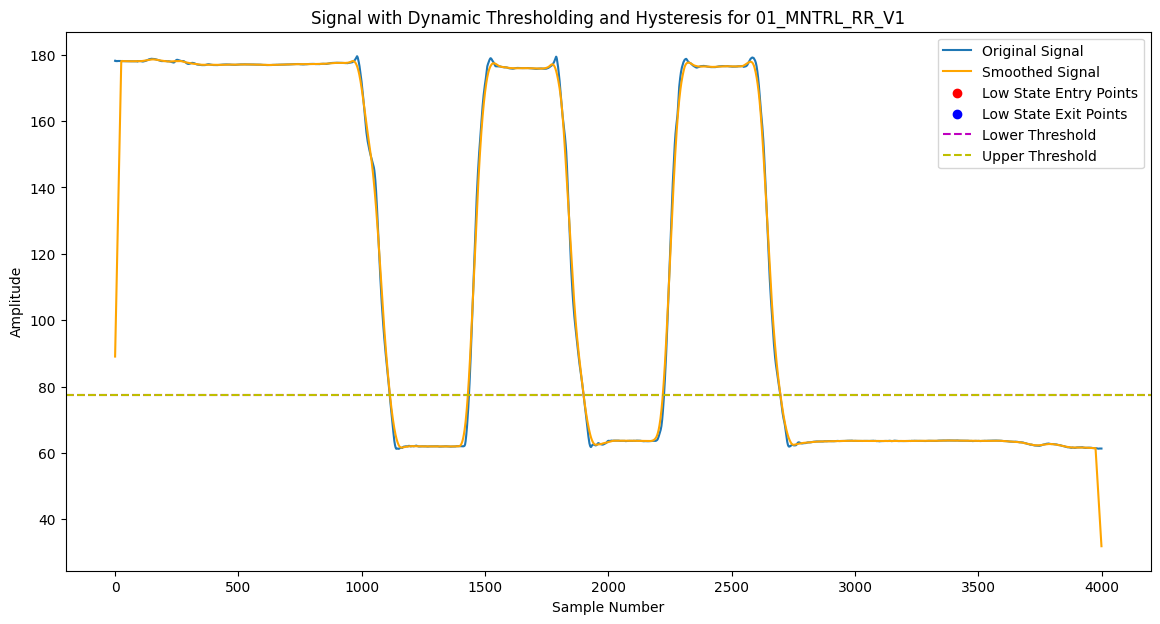

Used STD Factor: 0.75 (Iterative)
01_MNTRL_RR_V1: t_stable=11.6, t_break=14.28


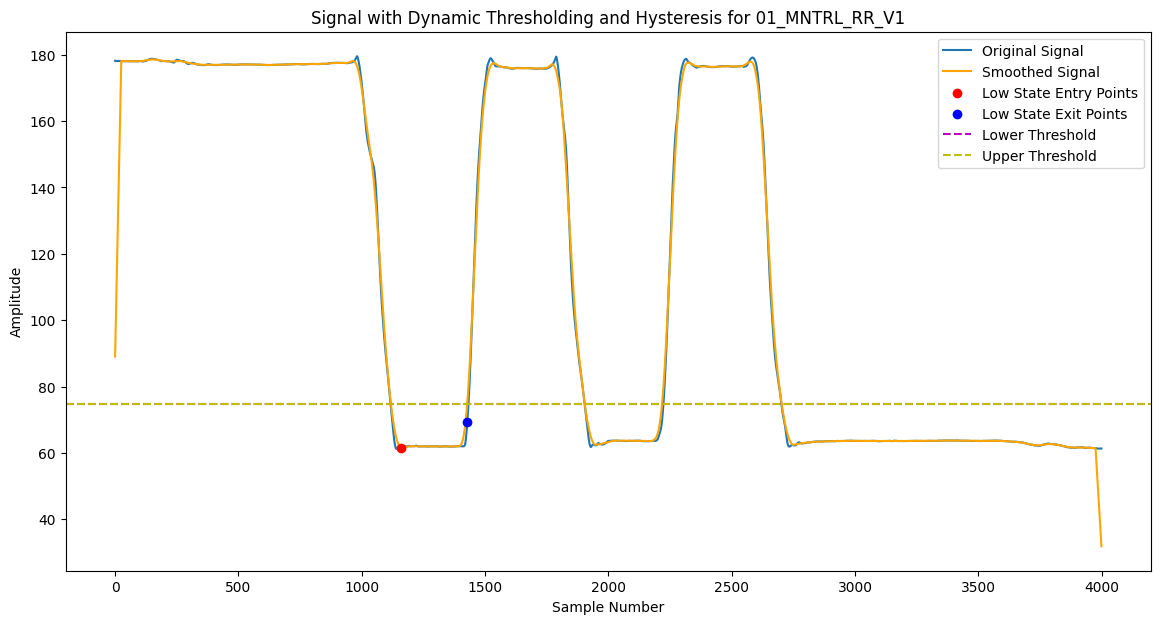

Used STD Factor: 0.75 (Fixed)
01_MNTRL_RR_V1: t_stable=11.19, t_break=None


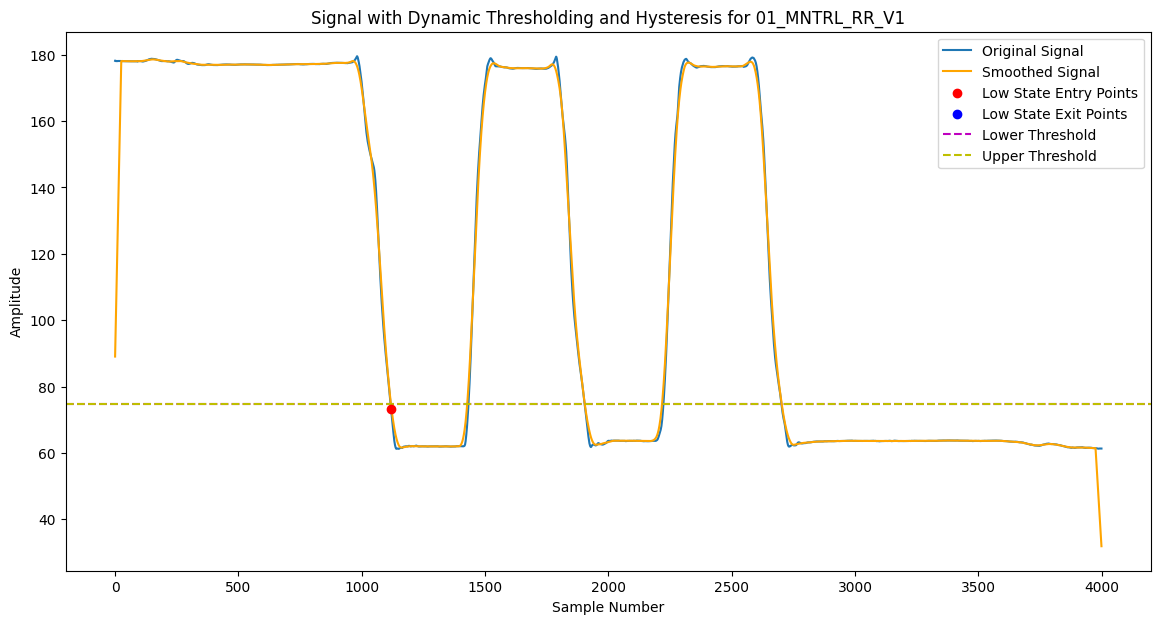

Used STD Factor: 0.75 (Iterative)
01_MNTRL_RR_V2: t_stable=11.36, t_break=14.27


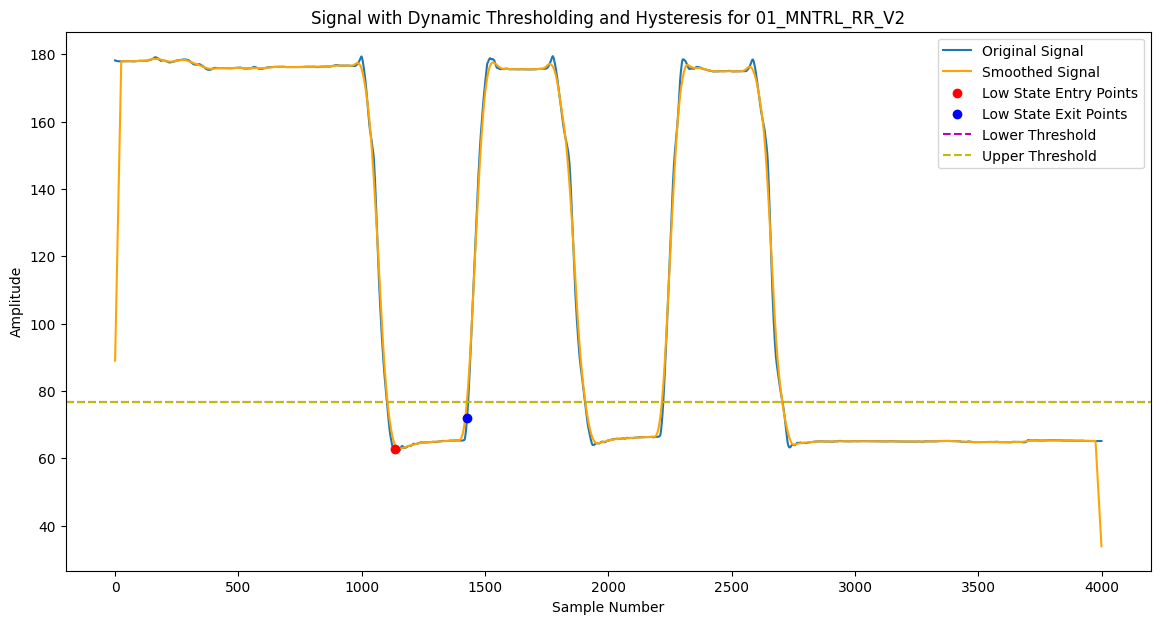

Used STD Factor: 0.75 (Iterative)
01_MNTRL_RR_V2: t_stable=11.36, t_break=14.27


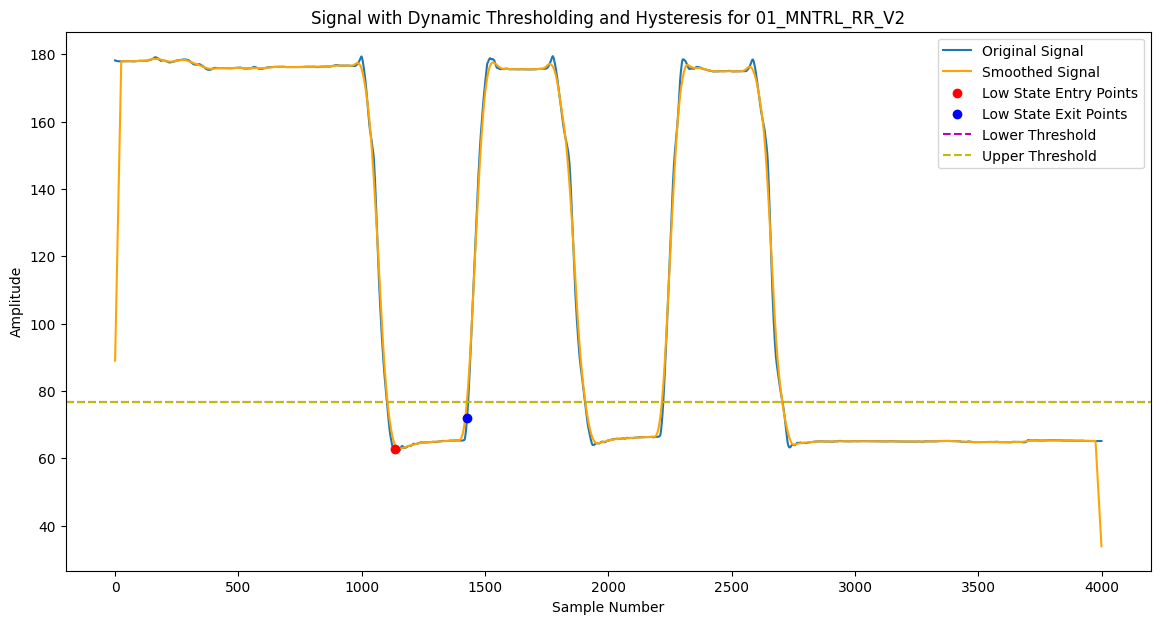

Used STD Factor: 0.75 (Fixed)
01_MNTRL_RR_V2: t_stable=11.05, t_break=None


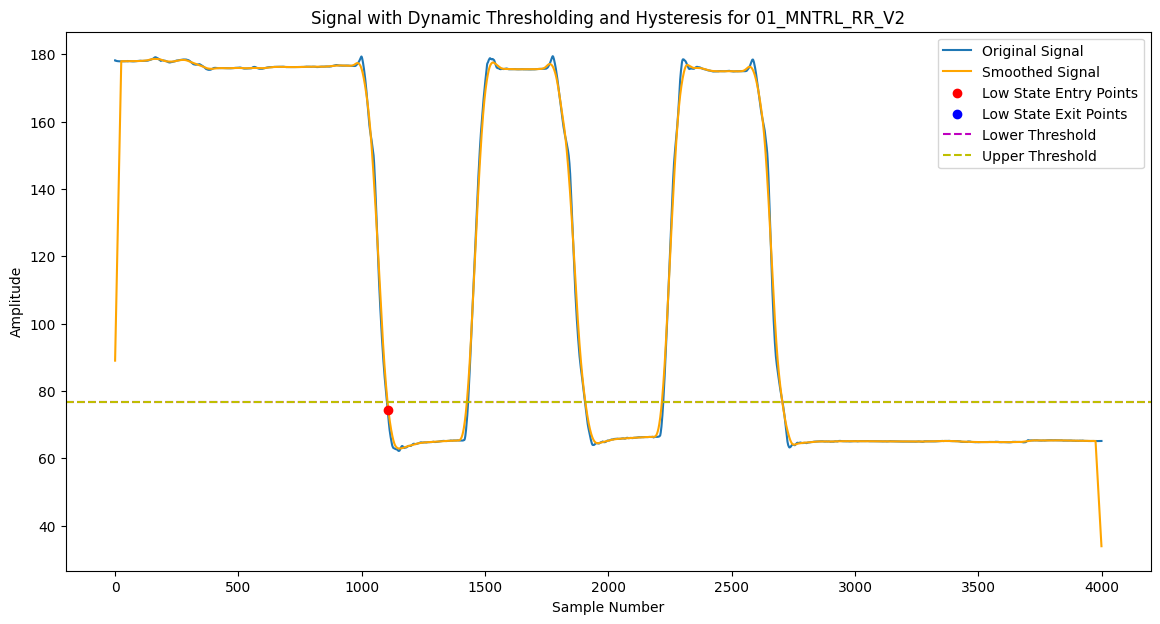

Used STD Factor: 0.75 (Iterative)
01_MNTRL_RR_V3: t_stable=0.0, t_break=22.2


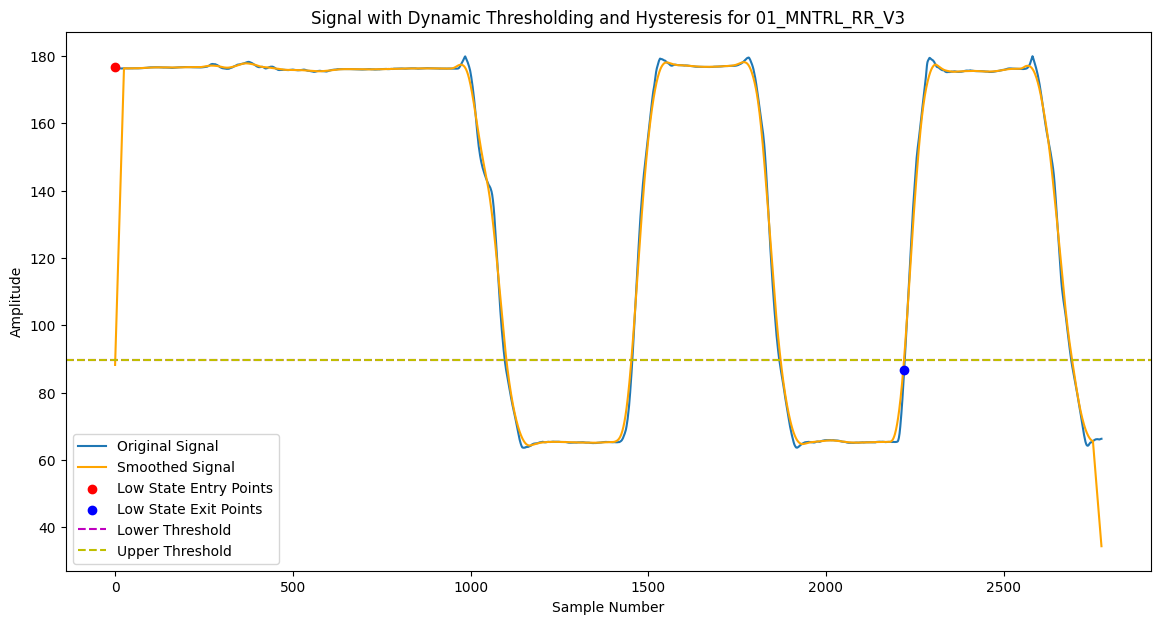

Used STD Factor: 0.75 (Fixed)
01_MNTRL_RR_V3: t_stable=0.0, t_break=None


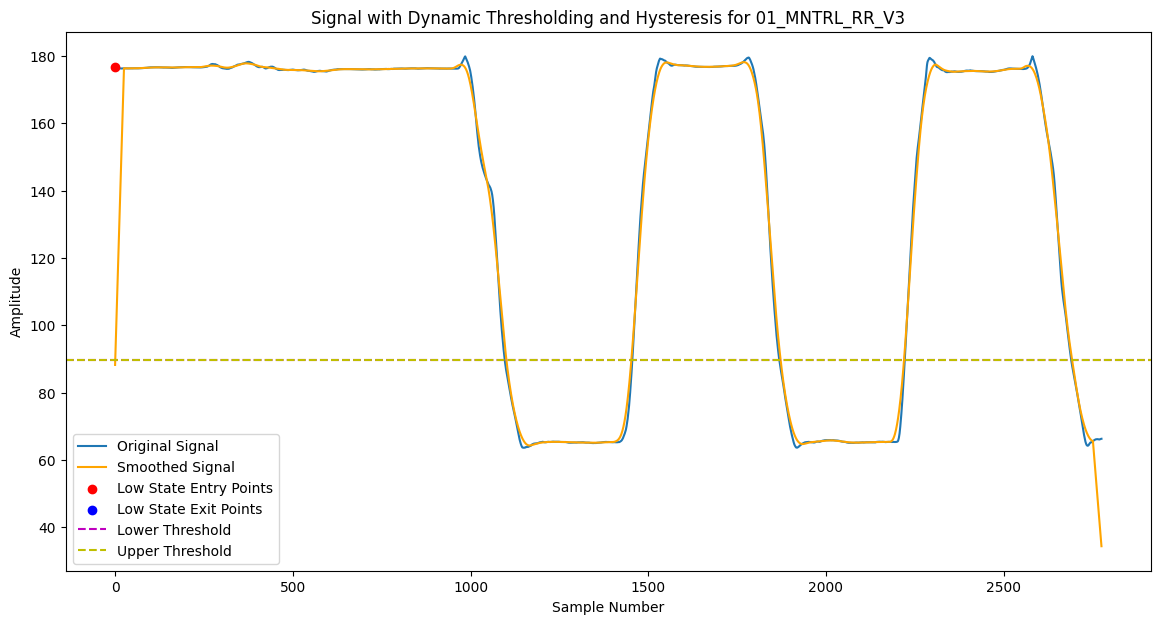

MOCAP CSV file not found: /Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/preprocessed/latest/all_knee_angle_csvs/01_MNTRR_MC_V1_pos_angle.csv
MOCAP CSV file not found: /Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/preprocessed/latest/all_knee_angle_csvs/01_MNTRR_MC_V1_pos_angle.csv
MOCAP CSV file not found: /Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/preprocessed/latest/all_knee_angle_csvs/01_MNTRR_MC_V1_pos_angle.csv
MOCAP CSV file not found: /Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/preprocessed/latest/all_knee_angle_csvs/01_MNTRR_MC_V2_pos_angle.csv
MOCAP CSV file not found: /Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/preprocessed/latest/all_knee_angle_csvs/01_MNTRR_MC_V2_pos_

KeyError: 'Start_Time'

In [15]:
# Set the sample frequency
SAMPLE_FREQ = 100  # MOCAP data is sampled at 100 Hz

# Path where the MOCAP CSV files are stored (same as output_folder)
csv_path = output_folder

# Add new columns for 't_stable' and 't_break' if they don't already exist
if 't_stable' not in df_captures.columns:
    df_captures['t_stable'] = None  # Initialize the column with None

if 't_break' not in df_captures.columns:
    df_captures['t_break'] = None  # Initialize the column with None

for idx, row in df_captures.iterrows():
    RADAR_capture = row['RADAR_capture']
    MOCAP_csv_file = RADAR_capture.replace('_RR_', '_MC_') + '_pos_angle.csv'
    MOCAP_csv_path = os.path.join(csv_path, MOCAP_csv_file)
    
    if os.path.exists(MOCAP_csv_path):
        df = pd.read_csv(MOCAP_csv_path)
        # Select the appropriate Knee angle based on movement
        if 'MNTRR' in RADAR_capture:
            signal = df['Knee_L_angle']
        elif 'MNTRL' in RADAR_capture:
            signal = df['Knee_R_angle']
        else:
            print(f"Unknown movement in RADAR_capture: {RADAR_capture}")
            continue
        
        # Get start_time and end_time in samples
        start_time = int(row['t_stable'] * SAMPLE_FREQ) if pd.notna(row['t_stable']) else 0
        end_time = int(row['t_break'] * SAMPLE_FREQ) if pd.notna(row['t_break']) else len(signal)
        
        # Adjust 'adjust_std' based on 'is_final_tx'
        adjust_std = row['is_final_tx']
        
        # Apply the dynamic thresholding with hysteresis function
        low_states_entry, low_states_exit, lower_threshold, upper_threshold = dynamic_thresholding_with_hysteresis(
            signal.to_numpy(), adjust_std, FU=start_time, FD=end_time, window_size=50)
        
        # Calculate 't_stable' and 't_break'
        # t_stable is the first low_states_entry after start_time
        t_stable_new = None
        for idx_entry in low_states_entry:
            if idx_entry >= start_time:
                t_stable_new = idx_entry / SAMPLE_FREQ
                break
        
        # t_break is the last low_states_exit before end_time
        t_break_new = None
        for idx_exit in reversed(low_states_exit):
            if idx_exit <= end_time:
                t_break_new = idx_exit / SAMPLE_FREQ
                break
        
        # Update the DataFrame with the calculated 't_stable' and 't_break'
        df_captures.at[idx, 't_stable'] = t_stable_new
        df_captures.at[idx, 't_break'] = t_break_new
        
        print(f"{RADAR_capture}: t_stable={t_stable_new}, t_break={t_break_new}")
        
        smoothed_signal = smooth_signal(signal, window_size=50)
        
        #Optionally, plot the results
        plt.figure(figsize=(14, 7))
        plt.plot(signal, label='Original Signal')
        plt.plot(smoothed_signal, label='Smoothed Signal', color='orange')
        plt.scatter(low_states_entry, signal[low_states_entry], color='red', zorder=3, label='Low State Entry Points')
        plt.scatter(low_states_exit, signal[low_states_exit], color='blue', zorder=3, label='Low State Exit Points')
        plt.axhline(y=lower_threshold, color='m', linestyle='--', label='Lower Threshold')
        plt.axhline(y=upper_threshold, color='y', linestyle='--', label='Upper Threshold')
        plt.legend()
        plt.title(f'Signal with Dynamic Thresholding and Hysteresis for {RADAR_capture}')
        plt.xlabel('Sample Number')
        plt.ylabel('Amplitude')
        plt.show()
        
    else:
        print(f"MOCAP CSV file not found: {MOCAP_csv_path}")
        
        
# Calculate the number of frames from 't_stable' and 't_break' after 'Start_Time'
df_captures['frame_stable'] = (((pd.to_numeric(df_captures['t_stable'], errors='coerce') - df_captures['Start_Time']) / df_captures['Seconds_per_Frame']) + df_captures['Start_Frame']).round().astype('Int64')
df_captures['frame_break'] = (((pd.to_numeric(df_captures['t_break'], errors='coerce') - df_captures['Start_Time']) / df_captures['Seconds_per_Frame']) + df_captures['Start_Frame']).round().astype('Int64')
